In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import VQC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from IPython.display import clear_output

In [2]:
algorithm_globals.random_seed = 42
sampler1 = Sampler()
sampler2 = Sampler()

# Init dataset

In [3]:
size_sample = 40
size_train = 30
size_test = size_sample - size_train
num_feature = 3

subarrays = []
for _ in range(size_sample):
    subarray_length = random.randint(num_feature, num_feature)
    subarray_values = np.random.randint(0, 100, subarray_length)
    subarrays.append(subarray_values)

features = np.array(subarrays)

labels = np.zeros_like(features)
max_values = np.max(features, axis=1)
max_indices = np.argmax(features, axis=1)

labels[np.arange(features.shape[0]), max_indices] = 1

features = MinMaxScaler().fit_transform(features)

In [4]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=size_train, shuffle=False, random_state=algorithm_globals.random_seed
)

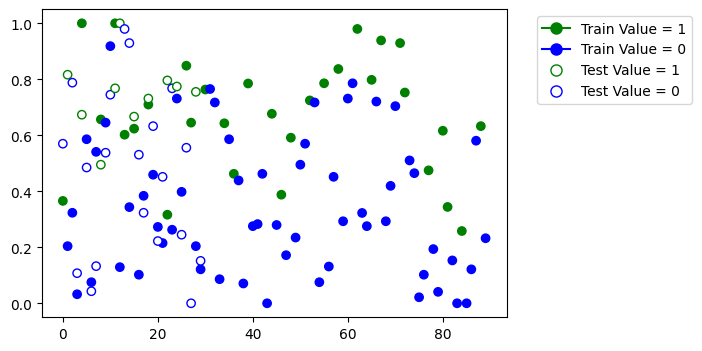

In [23]:
train_flattened_features = train_features.flatten()
train_flattened_labels = train_labels.flatten()

test_flattened_features = test_features.flatten()
test_flattened_labels = test_labels.flatten()

def plot_dataset():
    
    colors_feat = np.where(train_flattened_labels == 1, 'g', 'b')
    colors_test = np.where(test_flattened_labels == 1, 'g', 'b')

    plt.scatter(range(len(train_flattened_features)), train_flattened_features, 
                c=colors_feat, marker="o")

    plt.scatter(range(len(test_flattened_features)), test_flattened_features, 
                edgecolors=colors_test, facecolors="w", marker="o")

plot_dataset()

legend_elements = [
        plt.Line2D([0], [0], marker='o', color="g", markersize=8, label='Train Value = 1'),
        plt.Line2D([0], [0], marker='o', color='b', markersize=8, label='Train Value = 0'),
        plt.Line2D([0], [0], marker='o', color='w', markeredgecolor="g", markersize=8, label='Test Value = 1'),
        plt.Line2D([0], [0], marker='o', color="w", markeredgecolor="b", markersize=8, label='Test Value = 0')
    ]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Create & Train QNeural Network model

In [6]:
maxiter = 20
objective_values = []

In [7]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(_, objective_value):
    clear_output(wait=True)
    objective_values.append(objective_value)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")

    stage1_len = np.min((len(objective_values), maxiter))
    stage1_x = np.linspace(1, stage1_len, stage1_len)
    stage1_y = objective_values[:stage1_len]

    stage2_len = np.max((0, len(objective_values) - maxiter))
    stage2_x = np.linspace(maxiter, maxiter + stage2_len - 1, stage2_len)
    stage2_y = objective_values[maxiter : maxiter + stage2_len]

    plt.plot(stage1_x, stage1_y, color="orange")
    plt.plot(stage2_x, stage2_y, color="purple")
    plt.show()


plt.rcParams["figure.figsize"] = (12, 6)

In [8]:
original_optimizer = COBYLA(maxiter=maxiter)

ansatz = RealAmplitudes(num_feature)
initial_point = np.asarray([0.5] * ansatz.num_parameters)

In [9]:
original_classifier = VQC(
    ansatz=ansatz, optimizer=original_optimizer, callback=callback_graph, sampler=sampler1
)

### Fit with train data

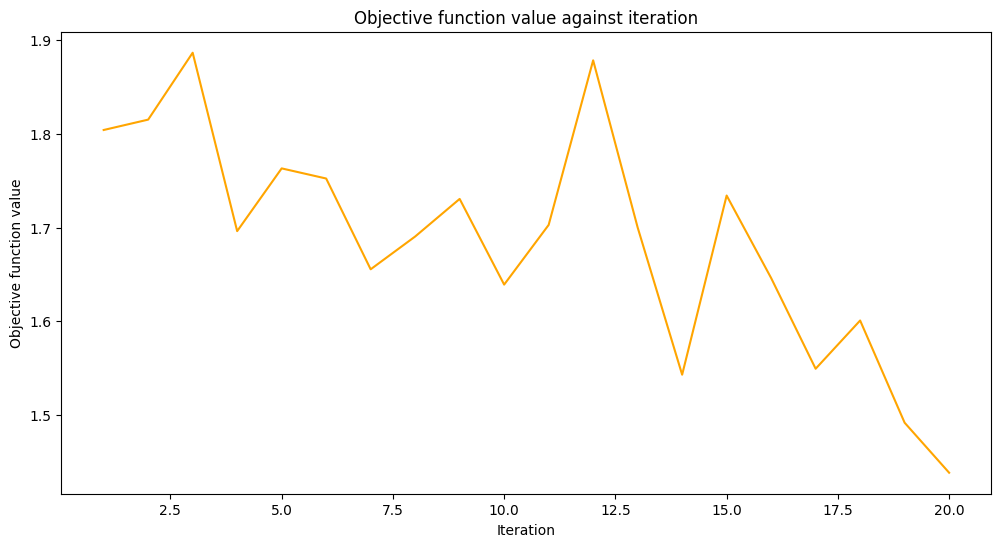

In [12]:
original_classifier.fit(train_features, train_labels)

In [13]:
print("Train score", original_classifier.score(train_features, train_labels))
print("Test score ", original_classifier.score(test_features, test_labels))

Train score 0.5333333333333333
Test score  0.5


In [14]:
original_classifier.save("resources/vqc_classifier.model")

### Fit with test data

In [15]:
loaded_classifier = VQC.load("resources/vqc_classifier.model")
loaded_classifier.warm_start = True
loaded_classifier.neural_network.sampler = sampler2
loaded_classifier.optimizer = COBYLA(maxiter=80)

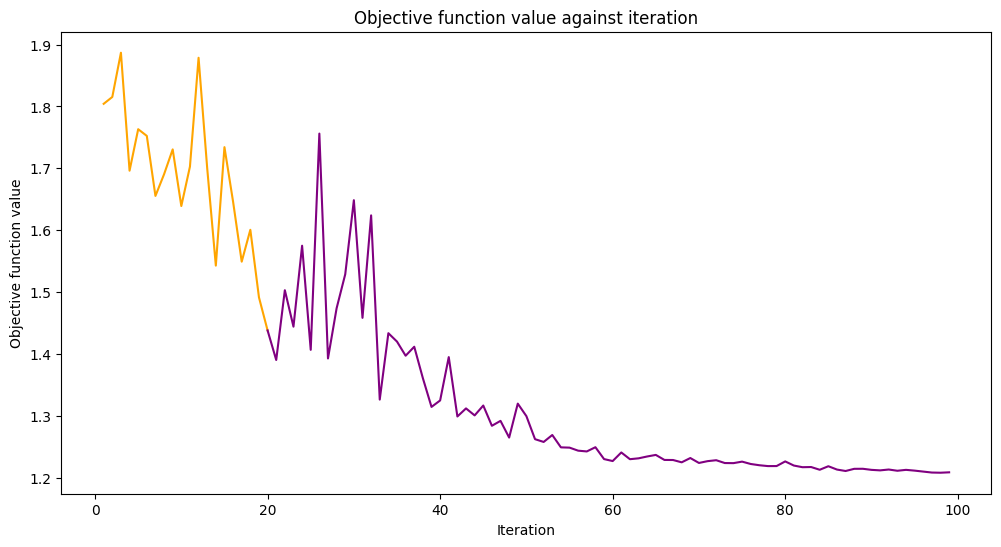

In [16]:
loaded_classifier.fit(train_features, train_labels)

In [17]:
print("Train score", loaded_classifier.score(train_features, train_labels))
print("Test score", loaded_classifier.score(test_features, test_labels))

Train score 0.7
Test score 0.5


## Test model

In [18]:
train_predicts = loaded_classifier.predict(train_features)
test_predicts = loaded_classifier.predict(test_features)

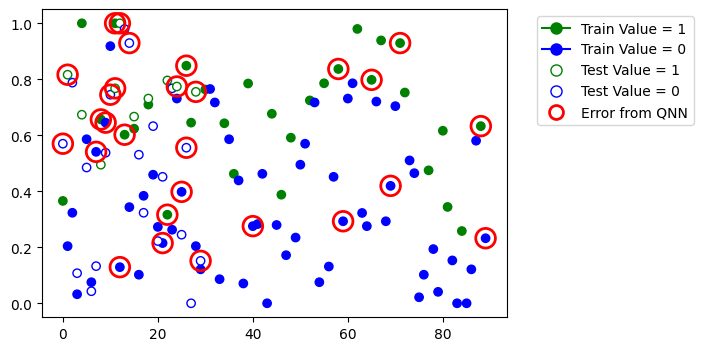

In [24]:
plt.rcParams["figure.figsize"] = (6, 4)

train_flattened_predicts = train_predicts.flatten()
test_flattened_predicts = test_predicts.flatten()

plot_dataset()

count_train = 0
count_test = 0
for train_predict, train_label, train_feat in zip(
    train_flattened_predicts, train_flattened_labels, train_flattened_features
):
    if not np.all(train_predict == train_label):
        index = np.where(train_flattened_features == train_feat)
        plt.scatter(index[0][0], train_feat, s=200,facecolors="none",edgecolors="r",linewidths=2)
        count_train += 1

for test_predict, test_label, test_feat in zip(
    test_flattened_predicts, test_flattened_labels, test_flattened_features
):
    if not np.all(test_predict == test_label):
        index = np.where(test_flattened_features == test_feat)
        plt.scatter(index[0][0], test_feat, s=200,facecolors="none",edgecolors="r",linewidths=2)
        count_test += 1
        

legend_elements += [
    plt.Line2D([0], [0], marker='o', color="w", markersize=10, markerfacecolor='none', markeredgecolor='red', markeredgewidth=2, label='Error from QNN')
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()

In [22]:
print("Error on train values : ", count_train)
print("Error on test values : ", count_test)

Error on train values :  18
Error on test values :  10
